In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal

from solardatatools import signal_decompositions as sd

np.random.seed(12) # reload each time to get first instance of seed

# Set up simple numerical examples for tests of  l2_l1d1_l2d2p365

In [2]:
t = np.linspace(0, 1000, 365*2)
signal1 = np.sin(2 * np.pi * t * 1 / (365.))
signal2 = signal.square(2 * np.pi * t * 1 / (365.))
X_real = np.zeros((3, len(t)), dtype=float)
X_real[0] = 0.15 * np.random.randn(len(signal1))
X_real[1] = signal1
X_real[2] = signal2
y = np.sum(X_real, axis=0)

K, T = X_real.shape

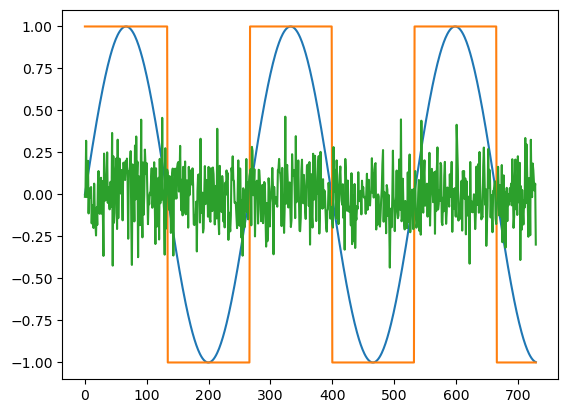

In [5]:
plt.plot(signal1)
plt.plot(signal2)
plt.plot(X_real[0])

## sav/load as df

In [3]:
fname = "test_l2_l1d1_l2d2p365_data_input.csv"
# try:
#     signal = pd.read_csv(fname)["test_signal"].array
#     test_df = pd.DataFrame(signal, columns=["test_signal"])
#     #df_full = pd.read_csv(fname)
# except FileNotFoundError:
test_df = pd.DataFrame(y, columns=["test_signal"]).round(7)

In [4]:
test_df.head(1)

,test_signal
0,1.070948


### CVXPY exepcted output
Try OSQP, SCS, ECOS, and MOSEK and confirm that all that run give the same objective value

## start w/ signal <= 365

In [4]:
signal_365 = test_df["test_signal"].array[:365]

### adjusted c1 from 10 to 2

In [5]:
s_hat, s_seas, obj_val = sd.l2_l1d1_l2d2p365(signal_365, c1=2, solver = "MOSEK", return_obj=True)

cols = test_df.columns
test_df = pd.concat([test_df, pd.Series(s_hat)], ignore_index=True, axis=1)
test_df.columns = list(cols) + ["expected_s_hat_mosek_365"]

cols = test_df.columns
test_df = pd.concat([test_df, pd.Series(s_seas)], ignore_index=True, axis=1)
test_df.columns = list(cols) + ["expected_s_seas_mosek_365"]

cols = test_df.columns
test_df = pd.concat([test_df, pd.Series(obj_val)], ignore_index=True, axis=1)
test_df.columns = list(cols) + ["expected_obj_val_mosek_365"]

In [7]:
# random weights 
rand_residual_weights = np.random.uniform(1, 2, len(signal_365)).round(7)
rand_tv_weights = np.random.uniform(1, 2, len(signal_365)-1).round(7)

cols = test_df.columns

test_df = pd.concat([test_df, pd.Series(rand_residual_weights)], ignore_index=True, axis=1)
test_df = pd.concat([test_df, pd.Series(rand_tv_weights)], ignore_index=True, axis=1)
test_df.columns = list(cols) + ["rand_residual_weights_365", "rand_tv_weights_365"]

### add resuts w/ weights

In [8]:
# MOSEK
s_hat, s_seas, obj_val = sd.l2_l1d1_l2d2p365(signal_365, c1=2.5, solver = "MOSEK", 
                                             return_obj=True, residual_weights=test_df["rand_residual_weights_365"].dropna())
cols = test_df.columns
test_df = pd.concat([test_df, pd.Series(s_hat)], ignore_index=True, axis=1)
test_df = pd.concat([test_df, pd.Series(s_seas)], ignore_index=True, axis=1)
test_df = pd.concat([test_df, pd.Series(obj_val)], ignore_index=True, axis=1)
test_df.columns = list(cols) + ["expected_s_hat_mosek_rw_365", 
                                "expected_s_seas_mosek_rw_365",
                                "expected_obj_val_mosek_rw_365"]

s_hat, s_seas, obj_val = sd.l2_l1d1_l2d2p365(signal_365, c1=2.5, solver = "MOSEK", 
                                             return_obj=True, tv_weights=test_df["rand_tv_weights_365"].dropna())
cols = test_df.columns
test_df = pd.concat([test_df, pd.Series(s_hat)], ignore_index=True, axis=1)
test_df = pd.concat([test_df, pd.Series(s_seas)], ignore_index=True, axis=1)
test_df = pd.concat([test_df, pd.Series(obj_val)], ignore_index=True, axis=1)
test_df.columns = list(cols) + ["expected_s_hat_mosek_tvw_365",
                                "expected_s_seas_mosek_tvw_365",
                                "expected_obj_val_mosek_tvw_365"]

### add transition pnt

In [13]:
# get indices of piecewise fn transitions

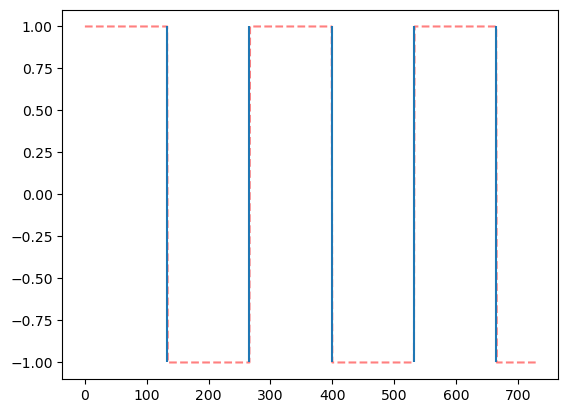

In [13]:
plt.plot(signal2, linestyle="--", alpha=0.5,  color="red")
plt.vlines(133, -1, 1)
plt.vlines(266, -1, 1)
plt.vlines(399, -1, 1)
plt.vlines(532, -1, 1)
plt.vlines(665, -1, 1)
#plt.xlim(530,535)

In [14]:
idx = [133, 266] # only up to index 365 since not taking the full one here
cols = test_df.columns

s_hat, s_seas, obj_val = sd.l2_l1d1_l2d2p365(signal_365, solver = "MOSEK", transition_locs=idx, return_obj=True)
test_df = pd.concat([test_df, pd.Series(s_hat)], ignore_index=True, axis=1)
test_df = pd.concat([test_df, pd.Series(s_seas)], ignore_index=True, axis=1)
test_df = pd.concat([test_df, pd.Series(obj_val)], ignore_index=True, axis=1)


test_df.columns = list(cols) + ["expected_s_hat_mosek_transition_365", 
                                "expected_s_seas_mosek_transition_365",
                                "expected_obj_val_mosek_transition_365"]

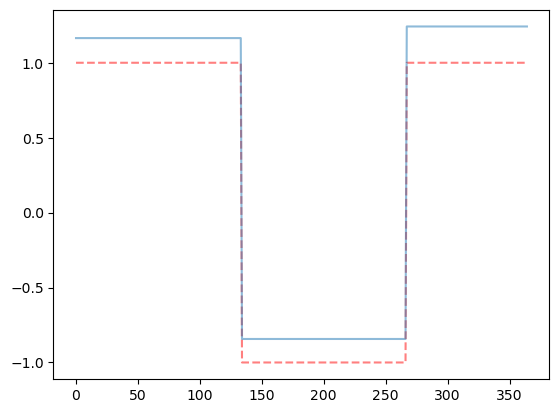

In [15]:
plt.plot(signal2[:365], linestyle="--", alpha=0.5,  color="red")
plt.plot(test_df["expected_s_hat_mosek_transition_365"], alpha=0.5,)

In [16]:
idx_wrong = [100, 308]
cols = test_df.columns

s_hat, s_seas, obj_val = sd.l2_l1d1_l2d2p365(signal_365, solver = "MOSEK", transition_locs=idx_wrong, return_obj=True)
test_df = pd.concat([test_df, pd.Series(s_hat)], ignore_index=True, axis=1)
test_df = pd.concat([test_df, pd.Series(s_seas)], ignore_index=True, axis=1)
test_df = pd.concat([test_df, pd.Series(obj_val)], ignore_index=True, axis=1)


test_df.columns = list(cols) + ["expected_s_hat_mosek_transition_wrong_365", 
                                "expected_s_seas_mosek_transition_wrong_365",
                                "expected_obj_val_mosek_transition_wrong_365"]

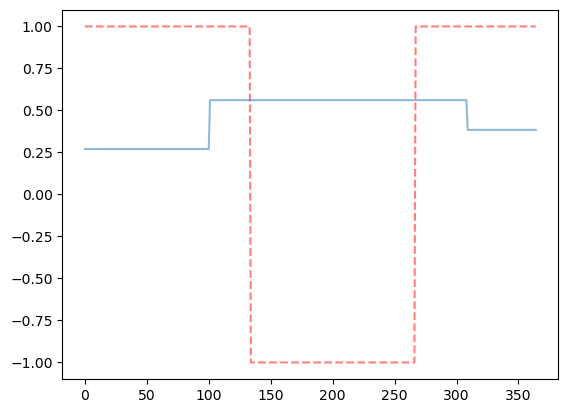

In [17]:
plt.plot(signal2[:365], linestyle="--", alpha=0.5,  color="red")
plt.plot(test_df["expected_s_hat_mosek_transition_wrong_365"], alpha=0.5,)

### max seas constraint  

In [18]:
cols = test_df.columns

# MOSEK
s_hat, s_seas, obj_val = sd.l2_l1d1_l2d2p365(signal_365, solver = "MOSEK", seas_max=0.5, return_obj=True) # is this reasonable?
test_df = pd.concat([test_df, pd.Series(s_hat)], ignore_index=True, axis=1)
test_df = pd.concat([test_df, pd.Series(s_seas)], ignore_index=True, axis=1)
test_df = pd.concat([test_df, pd.Series(obj_val)], ignore_index=True, axis=1)

test_df.columns = list(cols) + ["expected_s_hat_mosek_seas_max_365", 
                                "expected_s_seas_mosek_seas_max_365",
                                "expected_obj_val_mosek_seas_max_365"]

In [19]:
test_df = test_df.round(7)

## signal w/ len > 365

In [20]:
signal_730 = test_df["test_signal"].array
# cvxpy output w/ default args

# MOSEK
s_hat, s_seas, obj_val = sd.l2_l1d1_l2d2p365(signal_730, c1=2, solver = "MOSEK", return_obj=True)
test_df["expected_s_hat_mosek"] = s_hat
test_df["expected_s_seas_mosek"] = s_seas
test_df["expected_obj_val_mosek"] = obj_val

#############################################################
# w/ random weights 
rand_residual_weights = np.random.uniform(1, 100, len(signal_730)).round(7)
rand_tv_weights = np.random.uniform(10, 200, len(signal_730)-1).round(7)
test_df["rand_residual_weights"] = rand_residual_weights

In [21]:
cols = test_df.columns 
test_df = pd.concat([test_df, pd.Series(rand_tv_weights)], ignore_index=True, axis=1)

test_df.columns = list(cols) + ["rand_tv_weights"]

# MOSEK
s_hat, s_seas, obj_val = sd.l2_l1d1_l2d2p365(signal_730,  c1=2.5, solver = "MOSEK",
                                             return_obj=True, residual_weights=test_df["rand_residual_weights"])
test_df["expected_s_hat_mosek_rw"] = s_hat
test_df["expected_s_seas_mosek_rw"] = s_seas
test_df["expected_obj_val_mosek_rw"] = obj_val

s_hat, s_seas, obj_val = sd.l2_l1d1_l2d2p365(signal_730, c1=2.5, solver = "MOSEK", 
                                             return_obj=True, tv_weights=test_df["rand_tv_weights"].dropna())
test_df["expected_s_hat_mosek_tvw"] = s_hat
test_df["expected_s_seas_mosek_tvw"] = s_seas
test_df["expected_obj_val_mosek_tvw"] = obj_val

#############################################################
# random transition pnt
idx = [164, 328, 492, 656]

# MOSEK
s_hat, s_seas, obj_val = sd.l2_l1d1_l2d2p365(signal_730, solver = "MOSEK", transition_locs=idx, return_obj=True)
test_df["expected_s_hat_mosek_transition_100"] = s_hat
test_df["expected_s_seas_mosek_transition_100"] = s_seas
test_df["expected_obj_val_mosek_transition_100"] = obj_val

#############################################################
# max seas constraint

# MOSEK
s_hat, s_seas, obj_val = sd.l2_l1d1_l2d2p365(signal_730, solver = "MOSEK", seas_max=0.5, return_obj=True) # is this reasonable?
test_df["expected_s_hat_mosek_seas_max"] = s_hat
test_df["expected_s_seas_mosek_seas_max"] = s_seas
test_df["expected_obj_val_mosek_seas_max"] = obj_val

In [22]:
#############################################################
# Take first 300 days of dataset
indices = list([True]*300) + list([False]*(len(signal_730)-300))

# MOSEK
s_hat, s_seas, obj_val = sd.l2_l1d1_l2d2p365(signal_730, c1=2, solver = "MOSEK", use_ixs=indices, return_obj=True)
test_df["expected_s_hat_mosek_ixs"] = s_hat
test_df["expected_s_seas_mosek_ixs"] = s_seas
test_df["expected_obj_val_mosek_ixs"] = obj_val

In [23]:
#############################################################
# yearly periodic constraint, len has to be >365

# MOSEK
s_hat, s_seas, obj_val = sd.l2_l1d1_l2d2p365(signal_730,  c1=1, solver = "MOSEK", yearly_periodic=True, return_obj=True)
test_df["expected_s_hat_mosek_yearly_periodic"] = s_hat
test_df["expected_s_seas_mosek_yearly_periodic"] = s_seas
test_df["expected_obj_val_mosek_yearly_periodic"] = obj_val

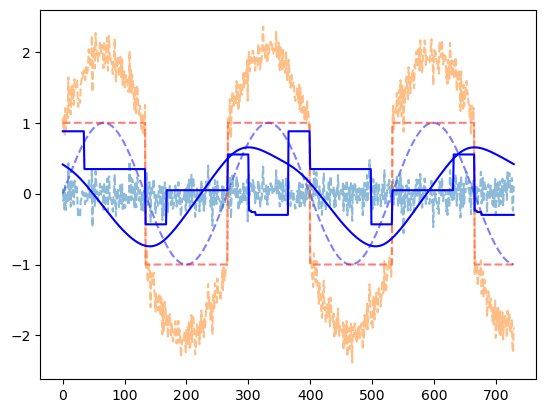

In [24]:
# tweak l1 params if off
plt.plot(signal1, linestyle="--", alpha=0.5, color="blue")
plt.plot(signal2, linestyle="--", alpha=0.5,  color="red")
plt.plot(X_real[0],  linestyle="--", alpha=0.5)
plt.plot(test_df["test_signal"], linestyle="--", alpha=0.5)

plt.plot(test_df["expected_s_seas_mosek_yearly_periodic"], color="blue")
plt.plot(test_df["expected_s_hat_mosek_yearly_periodic"], color="blue")

In [25]:
test_df = test_df.round(7)
test_df

,test_signal,expected_s_hat_mosek_365,expected_s_seas_mosek_365,expected_obj_val_mosek_365,rand_residual_weights_365,rand_tv_weights_365,expected_s_hat_mosek_rw_365,expected_s_seas_mosek_rw_365,expected_obj_val_mosek_rw_365,expected_s_hat_mosek_tvw_365,...,expected_obj_val_mosek_transition_100,expected_s_hat_mosek_seas_max,expected_s_seas_mosek_seas_max,expected_obj_val_mosek_seas_max,expected_s_hat_mosek_ixs,expected_s_seas_mosek_ixs,expected_obj_val_mosek_ixs,expected_s_hat_mosek_yearly_periodic,expected_s_seas_mosek_yearly_periodic,expected_obj_val_mosek_yearly_periodic
0,1.070948,1.071832,-0.049738,40.18183,1.901030,1.042992,1.023384,-0.014117,56.28807,1.059651,...,238.472997,1.389629,0.154766,221.510387,0.506584,0.554088,39.126031,0.880351,0.411865,413.98498
1,0.921397,1.071832,-0.030163,NaN,1.206654,1.586453,1.023384,0.007225,NaN,1.059651,...,238.472997,1.389629,0.145057,221.510387,0.506584,0.562024,39.126031,0.880351,0.406365,413.98498
2,1.083575,1.071832,-0.010585,NaN,1.492222,1.282554,1.023384,0.028576,NaN,1.059651,...,238.472997,1.389629,0.135505,221.510387,0.506584,0.569970,39.126031,0.880351,0.400793,413.98498
3,0.815671,1.071832,0.008991,NaN,1.659901,1.175179,1.023384,0.049937,NaN,1.059651,...,238.472997,1.389629,0.126130,221.510387,0.506584,0.577924,39.126031,0.880351,0.395141,413.98498
4,1.207285,1.071832,0.028564,NaN,1.820012,1.559077,1.023384,0.071315,NaN,1.059651,...,238.472997,1.389629,0.116948,221.510387,0.506584,0.585884,39.126031,0.880351,0.389404,413.98498
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,-1.857647,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,238.472997,-2.034635,0.205992,221.510387,1.655750,0.514529,39.126031,-0.299330,0.437900,413.98498
726,-1.768643,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,238.472997,-2.034635,0.195601,221.510387,1.655750,0.522437,39.126031,-0.299330,0.432805,413.98498
727,-2.188499,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,238.472997,-2.034635,0.185245,221.510387,1.655750,0.530344,39.126031,-0.299330,0.427665,413.98498
728,-2.236403,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,238.472997,-2.034635,0.174951,221.510387,1.655750,0.538253,39.126031,-0.299330,0.422475,413.98498


In [30]:
test_df.to_csv(fname, float_format='%.7f')

# Set up simple numerical examples for tests of l1_l2d2p365

In [32]:
"""
'l1_l2d2p365': estimating a smooth, seasonal component with a laplacian
noise model, fitting a local median instead of a local average
    - l1: laplacian noise, sum-of-absolute values or l1-norm
    - l2d2p365: small second order diffs (smooth) and 365-periodic
""";

In [58]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from solardatatools import signal_decompositions as sd

np.random.seed(12) # reload each time to get first instance of seed

In [57]:
t = np.linspace(0, 1000, 365*2)
# seasonal periodic
signal1 = np.sin(2 * np.pi * t * 1 / (365.))
X_real = np.zeros((2, len(t)), dtype=float)
# laplacian noise
X_real[0] = 0.15 * np.random.laplace(0, 1, len(signal1))
X_real[1] = signal1

y = np.sum(X_real, axis=0)

K, T = X_real.shape

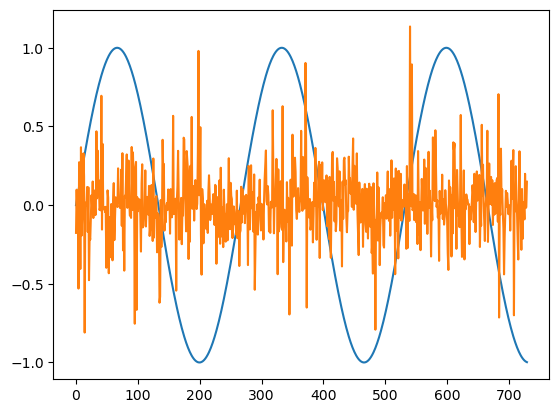

In [60]:
plt.plot(signal1)
plt.plot(X_real[0])

In [11]:
test_df = pd.DataFrame(y, columns=["test_signal"]).round(7)

In [12]:
signal_365 = test_df["test_signal"].array[:365]

In [13]:
# default 
s_seas, obj_val = sd.l1_l2d2p365(signal_365, solver = "MOSEK", return_obj=True)

cols = test_df.columns
test_df = pd.concat([test_df, pd.Series(s_seas)], ignore_index=True, axis=1)
test_df.columns = list(cols) + ["expected_s_seas_mosek_365"]

cols = test_df.columns
test_df = pd.concat([test_df, pd.Series(obj_val)], ignore_index=True, axis=1)
test_df.columns = list(cols) + ["expected_obj_val_mosek_365"]

In [38]:
# use_ixs

# take full signal
signal_730 = test_df["test_signal"].array

# Take first 300 days of dataset
indices = list([True]*300) + list([False]*(len(signal_730)-300))

# MOSEK
s_seas, obj_val = sd.l1_l2d2p365(signal_730, solver = "MOSEK", use_ixs=indices, return_obj=True)
test_df["expected_s_seas_mosek_ixs"] = s_seas
test_df["expected_obj_val_mosek_ixs"] = obj_val

In [46]:
# yearly periodic and >365
s_seas, obj_val = sd.l1_l2d2p365(signal_730, solver = "MOSEK", yearly_periodic=True, return_obj=True)

test_df["expected_s_seas_mosek_yearly_periodic"] = s_seas
test_df["expected_obj_val_mosek_yearly_periodic"] = obj_val

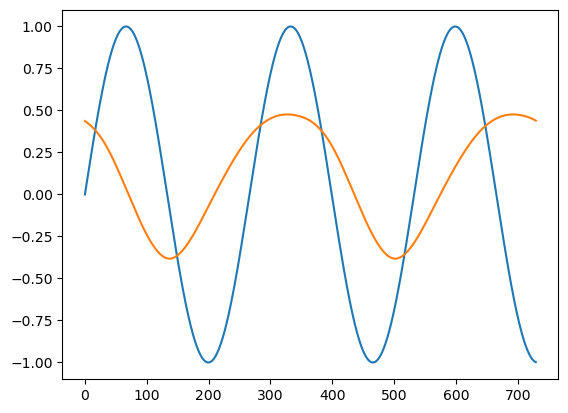

In [47]:
plt.plot(signal1)
plt.plot(s_seas)

In [48]:
test_df = test_df.round(7)
test_df

,test_signal,expected_s_seas_mosek_365,expected_obj_val_mosek_365,expected_s_seas_mosek_ixs,expected_obj_val_mosek_ixs,expected_s_seas_mosek_yearly_periodic,expected_obj_val_mosek_yearly_periodic
0,-0.176490,0.034030,61.393493,0.339105,57.137527,0.437069,439.655682
1,0.121729,0.055704,NaN,0.341692,57.137527,0.434581,439.655682
2,-0.048979,0.077370,NaN,0.344840,57.137527,0.432004,439.655682
3,0.081261,0.099028,NaN,0.348556,57.137527,0.429334,439.655682
4,-0.435982,0.120671,NaN,0.352842,57.137527,0.426571,439.655682
...,...,...,...,...,...,...,...
725,-1.078016,NaN,NaN,0.338868,57.137527,0.447458,439.655682
726,-0.791826,NaN,NaN,0.337827,57.137527,0.445560,439.655682
727,-1.012468,NaN,NaN,0.337259,57.137527,0.443583,439.655682
728,-1.008729,NaN,NaN,0.337182,57.137527,0.441524,439.655682


In [49]:
fname = "test_l1_l2d2p365_data_input.csv"
test_df.to_csv(fname, float_format='%.7f')

# Set up simple numerical examples for tests of tl1_l2d2p365

In [50]:
"""
'tl1_l2d2p365': similar to (2), estimating a smooth, seasonal component with
an asymmetric laplacian noise model, fitting a local quantile instead of a
local average
    - tl1: 'tilted l1-norm,' also known as quantile cost function
    - l2d2p365: small second order diffs (smooth) and 365-periodic
""";

In [87]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [90]:
from scipy.stats import laplace_asymmetric
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from solardatatools import signal_decompositions as sd

np.random.seed(12) # reload each time to get first instance of seed

In [91]:
t = np.linspace(0, 1000, 365*2)
# seasonal periodic
signal1 = np.sin(2 * np.pi * t * 1 / (365.))
X_real = np.zeros((2, len(t)), dtype=float)
# asymmetric laplacian noise
kappa = 2 # k>0, k=1 is laplace
X_real[0] = 0.15 * laplace_asymmetric.rvs(kappa, size=len(signal1))
X_real[1] = signal1

y = np.sum(X_real, axis=0)

K, T = X_real.shape

In [92]:
test_df = pd.DataFrame(y, columns=["test_signal"]).round(7)
signal_365 = test_df["test_signal"].array[:365]

In [78]:
# default 
s_seas, obj_val = sd.tl1_l2d2p365(signal_365, solver = "MOSEK", return_obj=True)

cols = test_df.columns
test_df = pd.concat([test_df, pd.Series(s_seas)], ignore_index=True, axis=1)
test_df.columns = list(cols) + ["expected_s_seas_mosek_365"]

cols = test_df.columns
test_df = pd.concat([test_df, pd.Series(obj_val)], ignore_index=True, axis=1)
test_df.columns = list(cols) + ["expected_obj_val_mosek_365"]

In [80]:
# use_ixs

# take full signal
signal_730 = test_df["test_signal"].array

# Take first 300 days of dataset
indices = list([True]*300) + list([False]*(len(signal_730)-300))

# MOSEK
s_seas, obj_val = sd.tl1_l2d2p365(signal_730, solver = "MOSEK", use_ixs=indices, return_obj=True)
test_df["expected_s_seas_mosek_ixs"] = s_seas
test_df["expected_obj_val_mosek_ixs"] = obj_val

In [82]:
# yearly periodic and >365
s_seas, obj_val = sd.tl1_l2d2p365(signal_730, solver = "MOSEK", yearly_periodic=True, return_obj=True)

test_df["expected_s_seas_mosek_yearly_periodic"] = s_seas
test_df["expected_obj_val_mosek_yearly_periodic"] = obj_val

In [84]:
test_df = test_df.round(7)
test_df

,test_signal,expected_s_seas_mosek_365,expected_obj_val_mosek_365,expected_s_seas_mosek_ixs,expected_obj_val_mosek_ixs,expected_s_seas_mosek_yearly_periodic,expected_obj_val_mosek_yearly_periodic
0,-0.642838,0.027527,32.823513,0.489186,32.094661,0.587271,156.394324
1,-0.479548,0.049369,NaN,0.491876,32.094661,0.582663,156.394324
2,-0.593795,0.071209,NaN,0.494815,32.094661,0.578209,156.394324
3,-0.361640,0.093044,NaN,0.498010,32.094661,0.573925,156.394324
4,0.090632,0.114868,NaN,0.501467,32.094661,0.569831,156.394324
...,...,...,...,...,...,...,...
725,-0.959128,NaN,NaN,0.481260,32.094661,0.613091,156.394324
726,-2.373192,NaN,NaN,0.482377,32.094661,0.607753,156.394324
727,-1.424706,NaN,NaN,0.483696,32.094661,0.602468,156.394324
728,-0.989610,NaN,NaN,0.485225,32.094661,0.597258,156.394324


In [85]:
fname = "test_tl1_l2d2p365_data_input.csv"
test_df.to_csv(fname, float_format='%.7f')

# Set up simple numerical examples for tests of tl1_l1d1_l2d2p365

In [86]:
"""
'tl1_l1d1_l2d2p365': like (1) but with an asymmetric residual cost instead
of Gaussian residuals
    - tl1: 'tilted l1-norm,' also known as quantile cost function
    - l1d1: piecewise constant heuristic, l1-norm of first order differences
    - l2d2p365: small second order diffs (smooth) and 365-periodic
""";

In [155]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [156]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal
from scipy.stats import laplace_asymmetric

from solardatatools import signal_decompositions as sd

np.random.seed(12) # reload each time to get first instance of seed

In [157]:
t = np.linspace(0, 1000, 365*2)
# seasonal term
signal1 = np.sin(2 * np.pi * t * 1 / (365.))
# piecewise constant term
signal2 = signal.square(2 * np.pi * t * 1 / (365.))
X_real = np.zeros((3, len(t)), dtype=float)
# asymmetric laplace noise 
kappa = 2 # k>0, k=1 is laplace
X_real[0] = 0.15 * laplace_asymmetric.rvs(kappa, size=len(signal1))
X_real[1] = signal1
X_real[2] = signal2
y = np.sum(X_real, axis=0)

K, T = X_real.shape

In [158]:
test_df = pd.DataFrame(y, columns=["test_signal"]).round(7)
signal_365 = test_df["test_signal"].array[:365]

In [159]:
# default 
s_hat, s_seas, obj_val = sd.tl1_l1d1_l2d2p365(signal_365, tau=0.995, c1=1000, c2=100, c3=100, solver = "MOSEK", return_obj=True)

cols = test_df.columns
test_df = pd.concat([test_df, pd.Series(s_hat)], ignore_index=True, axis=1)
test_df.columns = list(cols) + ["expected_s_hat_mosek_365"]

cols = test_df.columns
test_df = pd.concat([test_df, pd.Series(s_seas)], ignore_index=True, axis=1)
test_df.columns = list(cols) + ["expected_s_seas_mosek_365"]

cols = test_df.columns
test_df = pd.concat([test_df, pd.Series(obj_val)], ignore_index=True, axis=1)
test_df.columns = list(cols) + ["expected_obj_val_mosek_365"]

(0.0, 365.0)

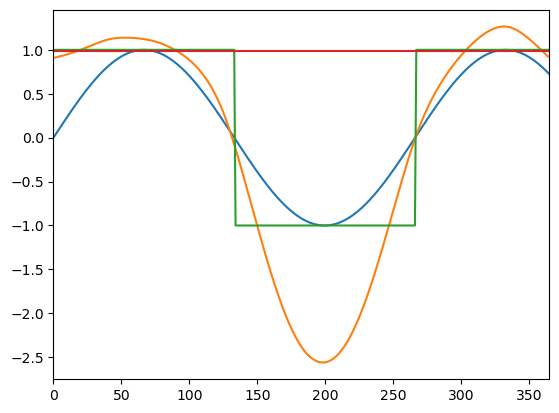

In [160]:
plt.plot(signal1)
plt.plot(s_seas)
plt.plot(signal2)
plt.plot(s_hat)
plt.xlim(0,365)

In [161]:
# use_ixs

# take full signal
signal_730 = test_df["test_signal"].array

# Take first 300 days of dataset
indices = list([True]*300) + list([False]*(len(signal_730)-300))

# MOSEK
s_hat, s_seas, obj_val = sd.tl1_l1d1_l2d2p365(signal_730, solver = "MOSEK", use_ixs=indices, return_obj=True)
test_df["expected_s_hat_mosek_ixs"] = s_hat
test_df["expected_s_seas_mosek_ixs"] = s_seas
test_df["expected_obj_val_mosek_ixs"] = obj_val

In [162]:
# random weights 
rand_residual_weights = np.random.uniform(1, 2, len(signal_365)).round(7)
rand_tv_weights = np.random.uniform(1, 2, len(signal_365)-1).round(7)

cols = test_df.columns

test_df = pd.concat([test_df, pd.Series(rand_residual_weights)], ignore_index=True, axis=1)
test_df = pd.concat([test_df, pd.Series(rand_tv_weights)], ignore_index=True, axis=1)
test_df.columns = list(cols) + ["rand_residual_weights_365", "rand_tv_weights_365"]

In [163]:
# MOSEK
s_hat, s_seas, obj_val = sd.tl1_l1d1_l2d2p365(signal_365, solver = "MOSEK", 
                                             return_obj=True, residual_weights=test_df["rand_residual_weights_365"].dropna())
cols = test_df.columns
test_df = pd.concat([test_df, pd.Series(s_hat)], ignore_index=True, axis=1)
test_df = pd.concat([test_df, pd.Series(s_seas)], ignore_index=True, axis=1)
test_df = pd.concat([test_df, pd.Series(obj_val)], ignore_index=True, axis=1)
test_df.columns = list(cols) + ["expected_s_hat_mosek_rw_365", 
                                "expected_s_seas_mosek_rw_365",
                                "expected_obj_val_mosek_rw_365"]

s_hat, s_seas, obj_val = sd.tl1_l1d1_l2d2p365(signal_365, solver = "MOSEK", 
                                             return_obj=True, tv_weights=test_df["rand_tv_weights_365"].dropna())
cols = test_df.columns
test_df = pd.concat([test_df, pd.Series(s_hat)], ignore_index=True, axis=1)
test_df = pd.concat([test_df, pd.Series(s_seas)], ignore_index=True, axis=1)
test_df = pd.concat([test_df, pd.Series(obj_val)], ignore_index=True, axis=1)
test_df.columns = list(cols) + ["expected_s_hat_mosek_tvw_365",
                                "expected_s_seas_mosek_tvw_365",
                                "expected_obj_val_mosek_tvw_365"]

In [164]:
test_df = test_df.round(7)
test_df

,test_signal,expected_s_hat_mosek_365,expected_s_seas_mosek_365,expected_obj_val_mosek_365,expected_s_hat_mosek_ixs,expected_s_seas_mosek_ixs,expected_obj_val_mosek_ixs,rand_residual_weights_365,rand_tv_weights_365,expected_s_hat_mosek_rw_365,expected_s_seas_mosek_rw_365,expected_obj_val_mosek_rw_365,expected_s_hat_mosek_tvw_365,expected_s_seas_mosek_tvw_365,expected_obj_val_mosek_tvw_365
0,0.506019,0.981869,0.907300,4.301471,1.125703,0.862315,4.58193,1.805957,1.415720,0.963126,0.926234,5.733406,0.981869,0.907300,4.301471
1,1.000243,0.981869,0.911057,NaN,1.125703,0.863454,4.58193,1.410318,1.548807,0.963126,0.928479,NaN,0.981869,0.911057,NaN
2,0.713831,0.981869,0.914833,NaN,1.125703,0.864682,4.58193,1.266000,1.496515,0.963126,0.930759,NaN,0.981869,0.914833,NaN
3,0.949370,0.981869,0.918649,NaN,1.125703,0.866005,4.58193,1.736704,1.192813,0.963126,0.933108,NaN,0.981869,0.918649,NaN
4,-0.107278,0.981869,0.922522,NaN,1.125703,0.867429,4.58193,1.529287,1.877084,0.963126,0.935555,NaN,0.981869,0.922522,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,-2.309647,NaN,NaN,NaN,1.125703,0.859467,4.58193,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
726,-1.960059,NaN,NaN,NaN,1.125703,0.860125,4.58193,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
727,-2.172178,NaN,NaN,NaN,1.125703,0.860833,4.58193,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
728,-2.162344,NaN,NaN,NaN,1.125703,0.861598,4.58193,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [165]:
fname = "test_tl1_l1d1_l2d2p365_data_input.csv"
test_df.to_csv(fname, float_format='%.7f')